In [1]:
import csv
import cv2
import numpy as np
import tensorflow as tf
import random
from PIL import Image

In [2]:
lines = []

with open("./train_data/track_1_normal/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
            lines.append(line)

In [8]:
images = []
measurements = []
correction = [0, 0.2, -0.2]

for line in lines:
    measurement = float(line[3])
    if(measurement > -0.05 and measurement < 0.05 and random.random() > 0.4):
        continue
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('\\')[-1]
        current_path = './train_data/track_1_normal/IMG/' + filename
        #print('debugx', current_path)
        image = Image.open(current_path)
        image = np.array(image.convert('YCbCr'))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        images.append(image)
        measurements.append(measurement + correction[i])

In [9]:
augmented_images, augmented_measurements = [], []
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image, 1))
    augmented_measurements.append(measurement*-1.0)

(array([  2.06475058e-02,   2.75300077e-03,   1.37650039e-03,
          8.25900231e-03,   0.00000000e+00,   1.37650039e-03,
          0.00000000e+00,   0.00000000e+00,   2.47770069e-02,
          2.61535073e-02,   1.10120031e-02,   3.44125096e-02,
          6.33190177e-02,   1.37650039e-02,   9.63550270e-03,
          5.09305143e-02,   5.09305143e-02,   1.01861029e-01,
          1.05990530e-01,   1.65180046e-01,   1.84451052e-01,
          1.15626032e-01,   1.29391036e-01,   1.44532540e-01,
          1.66556547e-01,   1.81698051e-01,   2.38134567e-01,
          2.65664574e-01,   3.27607092e-01,   3.41372096e-01,
          3.04206585e-01,   3.05583086e-01,   4.68010131e-01,
          4.17079617e-01,   4.30844621e-01,   5.98777668e-01,
          6.46955181e-01,   6.15295672e-01,   8.87842749e-01,
          7.66710715e-01,   5.82259663e-01,   3.49906398e+00,
          6.01530668e-01,   8.25900231e-01,   1.07917630e+00,
          9.20878758e-01,   1.02824579e+00,   1.13974232e+00,
        

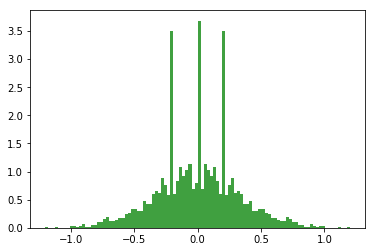

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(augmented_measurements, 100, normed=1, facecolor='green', alpha=0.75)

In [11]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

dropout_rate=0.5

model = Sequential()
model.add(Lambda(lambda x: x /255.0 - 0.5, input_shape=(160,320,3)))
# input 3@160x320
model.add(Cropping2D(cropping=((70,25), (0,0))))
# input 3@65x320
model.add(Convolution2D(24, 5, 5, activation="relu", subsample=(2,2)))
# input 24@31x158
model.add(Convolution2D(36, 5, 5, activation="relu", subsample=(2,2)))
# input 36@14x77
model.add(Convolution2D(48, 5, 5, activation="relu", subsample=(2,2)))
# input 48@5x37
model.add(Convolution2D(64, 3, 3, activation="relu"))
# input 64@3x35
model.add(Convolution2D(64, 3, 3, activation="relu"))
# input 64@1x32
model.add(Flatten())
model.add(Dropout(dropout_rate))
model.add(Dense(1164))
model.add(Dropout(dropout_rate))
model.add(Dense(100))
model.add(Dropout(dropout_rate))
model.add(Dense(50))
model.add(Dropout(dropout_rate))
model.add(Dense(10))
model.add(Dropout(dropout_rate))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

Using TensorFlow backend.


In [12]:
X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

history = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)

model.save('model.h5')

Train on 24216 samples, validate on 6054 samples
Epoch 1/5
24216/24216 [==============================] - 38s - loss: 0.0749 - val_loss: 0.0420
Epoch 2/5
24216/24216 [==============================] - 34s - loss: 0.0617 - val_loss: 0.0393
Epoch 3/5
24216/24216 [==============================] - 34s - loss: 0.0565 - val_loss: 0.0394
Epoch 4/5
24216/24216 [==============================] - 34s - loss: 0.0524 - val_loss: 0.0408
Epoch 5/5
24216/24216 [==============================] - 34s - loss: 0.0498 - val_loss: 0.0373


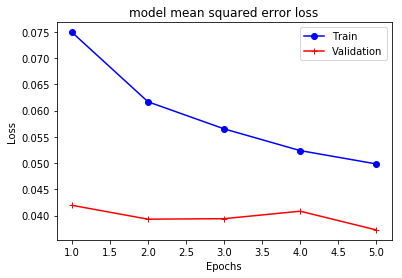

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo-', label='Train')
plt.plot(epochs, val_loss_values, 'r+-', label='Validation')
plt.xlabel('Epochs')
plt.title('model mean squared error loss')
plt.ylabel('Loss')
plt.legend()
plt.show()